In [8]:
%matplotlib inline
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
import nbimporter
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
import _spin_params as spin_pars
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes_wait, solve_mbes
#matplotlib.pyplot.switch_backend('nbAgg')
#%qtconsole

In [9]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr;
kappa = np.pi*fr/quali #HWHM
delta = spin_pars.delta #detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac #detuning drive to cavity wc-wp
gperp = spin_pars.gperp #HWHM
gpar = spin_pars.gpar#0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins#701#5000#20
nbins = spin_pars.nbins
g_number = spin_pars.g_number #how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

4.174817177486928


In [10]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund
    
    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002)*(1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse

def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)
    
    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004)*(1-logistic.cdf(t, loc=tend-0.02, scale=0.004))
    
    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq


In [11]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)

x_start = 5
x_stop = 20 #µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

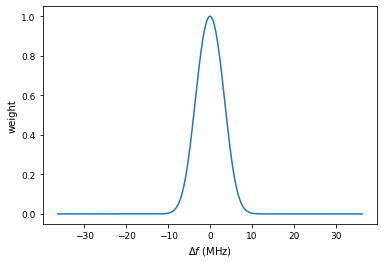

In [12]:
spins, gs, pdf = create_spins_inhomo_g(gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

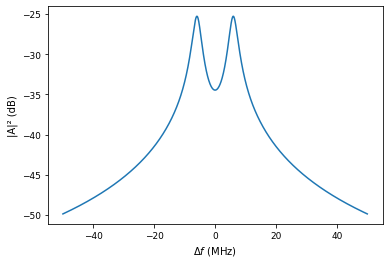

In [13]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [17]:
pumptime = 20e-3#5*np.pi/gcoll
decaytime = 12000e-3
inittime = 2000e-3
dt = 4e-3 #The time resolution of the AWG. Don't change that because the solution of the MBEs are written in a way that use that as time resolution
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)
tlistinit = np.arange(0, inittime+dt, dt)
# test time it takes to calculate
middle = int(nbins/2)

init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0
init[2::2] = np.array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -0.99999999,
       -0.99999999, -0.99999999, -0.99999999, -0.99999999, -0.99999999,
       -0.99999998, -0.99999998, -0.99999998, -0.99999997, -0.99999997,
       -0.99999996, -0.99999995, -0.99999994, -0.99999993, -0.99999992,
       -0.9999999 , -0.99999989, -0.99999986, -0.99999984, -0.99999981,
       -0.99999977, -0.99999973, -0.99999968, -0.99999962, -0.99999954,
       -0.99999946, -0.99999936, -0.99999924, -0.9999991 , -0.99999893,
       -0.99999873, -0.9999985 , -0.99999823, -0.9999979 , -0.99999752,
       -0.99999707, -0.99999654, -0.99999592, -0.99999519, -0.99999432,
       -0.99999331, -0.99999213, -0.99999074, -0.99998912, -0.99998722,
       -0.99998499, -0.9999824 , -0.99997938, -0.99997585, -0.99997175,
       -0.99996698, -0.99996143, -0.999955  , -0.99994755, -0.99993892,
       -0.99992894, -0.99991741, -0.9999041 , -0.99988877, -0.99987111,
       -0.99985081, -0.9998275 , -0.99980075, -0.9997701 , -0.99973503,
       -0.99969495, -0.99964919, -0.99959701, -0.99953759, -0.99947002,
       -0.99939325, -0.99930617, -0.99920749, -0.99909582, -0.99896962,
       -0.99882715, -0.99866655, -0.99848572, -0.99828239, -0.99805404,
       -0.99779792, -0.99751103, -0.99719008, -0.99683149, -0.99643137,
       -0.99598547, -0.99548921, -0.9949376 , -0.99432529, -0.99364646,
       -0.99289488, -0.99206383, -0.99114611, -0.99013401, -0.98901929,
       -0.98779315, -0.98644626, -0.98496866, -0.98334984, -0.98157865,
       -0.97964335, -0.97753156, -0.97523029, -0.97272593, -0.97000425,
       -0.96705043, -0.96384906, -0.96038416, -0.95663923, -0.95259724,
       -0.94824074, -0.94355183, -0.93851226, -0.93310351, -0.9273068 ,
       -0.92110321, -0.91447376, -0.90739948, -0.89986154, -0.89184133,
       -0.88332057, -0.87428145, -0.86470673, -0.85457986, -0.84388515,
       -0.83260784, -0.82073429, -0.80825208, -0.79515015, -0.78141894,
       -0.7670505 , -0.7520386 , -0.73637889, -0.72006895, -0.70310842,
       -0.6854991 , -0.66724497, -0.64835231, -0.62882971, -0.60868811,
       -0.58794084, -0.5666036 , -0.54469444, -0.52223374, -0.49924418,
       -0.47575063, -0.45178012, -0.42736172, -0.40252643, -0.37730708,
       -0.35173818, -0.32585577, -0.2996973 , -0.27330143, -0.2467079 ,
       -0.21995733, -0.19309109, -0.16615106, -0.13917954, -0.11221902,
       -0.08531203, -0.05850101, -0.03182809, -0.00533503,  0.020937  ,
        0.04694749,  0.07265674,  0.09802593,  0.12301726,  0.14759403,
        0.17172067,  0.19536285,  0.21848749,  0.24106287,  0.26305856,
        0.28444554,  0.30519615,  0.32528412,  0.34468455,  0.36337393,
        0.3813301 ,  0.39853222,  0.41496079,  0.43059757,  0.44542558,
        0.45942905,  0.47259341,  0.48490522,  0.49635216,  0.506923  ,
        0.51660753,  0.52539655,  0.53328186,  0.5402562 ,  0.54631322,
        0.55144747,  0.55565438,  0.55893025,  0.56127219,  0.56267818,
        0.56314697,  0.56267818,  0.56127219,  0.55893025,  0.55565438,
        0.55144747,  0.54631322,  0.5402562 ,  0.53328186,  0.52539655,
        0.51660753,  0.506923  ,  0.49635216,  0.48490522,  0.47259341,
        0.45942905,  0.44542558,  0.43059757,  0.41496079,  0.39853222,
        0.3813301 ,  0.36337393,  0.34468455,  0.32528412,  0.30519615,
        0.28444554,  0.26305856,  0.24106287,  0.21848749,  0.19536285,
        0.17172067,  0.14759403,  0.12301726,  0.09802593,  0.07265674,
        0.04694749,  0.020937  , -0.00533503, -0.03182809, -0.05850101,
       -0.08531203, -0.11221902, -0.13917954, -0.16615106, -0.19309109,
       -0.21995733, -0.2467079 , -0.27330143, -0.2996973 , -0.32585577,
       -0.35173818, -0.37730708, -0.40252643, -0.42736172, -0.45178012,
       -0.47575063, -0.49924418, -0.52223374, -0.54469444, -0.5666036 ,
       -0.58794084, -0.60868811, -0.62882971, -0.64835231, -0.66724497,
       -0.6854991 , -0.70310842, -0.72006895, -0.73637889, -0.7520386 ,
       -0.7670505 , -0.78141894, -0.79515015, -0.80825208, -0.82073429,
       -0.83260784, -0.84388515, -0.85457986, -0.86470673, -0.87428145,
       -0.88332057, -0.89184133, -0.89986154, -0.90739948, -0.91447376,
       -0.92110321, -0.9273068 , -0.93310351, -0.93851226, -0.94355183,
       -0.94824074, -0.95259724, -0.95663923, -0.96038416, -0.96384906,
       -0.96705043, -0.97000425, -0.97272593, -0.97523029, -0.97753156,
       -0.97964335, -0.98157865, -0.98334984, -0.98496866, -0.98644626,
       -0.98779315, -0.98901929, -0.99013401, -0.99114611, -0.99206383,
       -0.99289488, -0.99364646, -0.99432529, -0.9949376 , -0.99548921,
       -0.99598547, -0.99643137, -0.99683149, -0.99719008, -0.99751103,
       -0.99779792, -0.99805404, -0.99828239, -0.99848572, -0.99866655,
       -0.99882715, -0.99896962, -0.99909582, -0.99920749, -0.99930617,
       -0.99939325, -0.99947002, -0.99953759, -0.99959701, -0.99964919,
       -0.99969495, -0.99973503, -0.9997701 , -0.99980075, -0.9998275 ,
       -0.99985081, -0.99987111, -0.99988877, -0.9999041 , -0.99991741,
       -0.99992894, -0.99993892, -0.99994755, -0.999955  , -0.99996143,
       -0.99996698, -0.99997175, -0.99997585, -0.99997938, -0.9999824 ,
       -0.99998499, -0.99998722, -0.99998912, -0.99999074, -0.99999213,
       -0.99999331, -0.99999432, -0.99999519, -0.99999592, -0.99999654,
       -0.99999707, -0.99999752, -0.9999979 , -0.99999823, -0.9999985 ,
       -0.99999873, -0.99999893, -0.9999991 , -0.99999924, -0.99999936,
       -0.99999946, -0.99999954, -0.99999962, -0.99999968, -0.99999973,
       -0.99999977, -0.99999981, -0.99999984, -0.99999986, -0.99999989,
       -0.9999999 , -0.99999992, -0.99999993, -0.99999994, -0.99999995,
       -0.99999996, -0.99999997, -0.99999997, -0.99999998, -0.99999998,
       -0.99999998, -0.99999999, -0.99999999, -0.99999999, -0.99999999,
       -0.99999999, -0.99999999, -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        ])


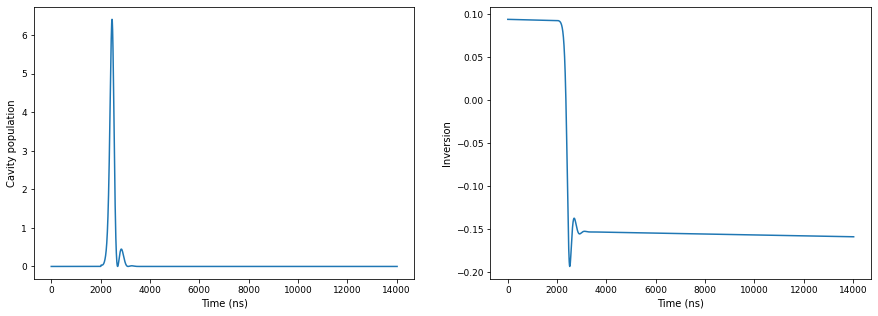

In [22]:
alos = np.zeros((len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))

asolinit, asolpump, asoldecay, infodict = solve_mbes_wait(mbes, init, pdf, tlistinit, tlist, tlistdecay,1e1, kappa, deltac, gs, gperp, spins, gpar)
alos = np.hstack((abs(asolinit[:,0])**2, abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
szlos = np.hstack((np.real(np.sum(asolinit[:, 2::2], axis=1)), np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
                  
tplot = np.linspace(0, 1000*(inittime+pumptime+decaytime), len(tlistinit)+len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(tplot, (alos))
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Cavity population');

ax2.plot(tplot, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion');

In [40]:
%qtconsole